# Citation

Much of the code and examples are copied/modified from 

> Blueprints for Text Analytics Using Python by Jens Albrecht, Sidharth Ramachandran, and Christian Winkler (O'Reilly, 2021), 978-1-492-07408-3.
>

- https://github.com/blueprints-for-text-analytics-python/blueprints-text
- https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch08/Topic_Modeling_Clustering.ipynb

---

# Setup

In [1]:
cd ../..

/Users/shanekercheval/repos/nlp-template


In [2]:
%run "source/config/notebook_settings.py"

In [3]:
pd.set_option('display.max_colwidth', None)

In [4]:
from source.library.utilities import Timer, get_logger
from source.library.text_analysis import count_tokens, tf_idf, get_context_from_keyword, count_keywords, count_keywords_by, impurity
from source.library.sklearn_topic_modeling import *

from helpsk.utility import read_pickle

In [5]:
ngrams_low = 1
ngrams_high = 3

In [7]:
with Timer("Loading Data"):
    path = 'artifacts/data/processed/un-general-debates-paragraphs.pkl'
    paragraphs = pd.read_pickle(path)
    
    file = f'artifacts/models/topics/nmf-topics-10-ngrams-{ngrams_low}-{ngrams_high}__vectorizer.pkl'
    nmf_vectorizer = read_pickle(file)

    file = f'artifacts/models/topics/nmf-topics-10-ngrams-{ngrams_low}-{ngrams_high}__vectors.pkl'
    nmf_vectors = read_pickle(file)
    
    file = f'artifacts/models/topics/nmf-topics-10-ngrams-{ngrams_low}-{ngrams_high}__model.pkl'  # noqa
    nmf_model = read_pickle(file)

    file = f'artifacts/models/topics/lda-topics-10-ngrams-{ngrams_low}-{ngrams_high}__vectorizer.pkl'
    lda_vectorizer = read_pickle(file)

    file = f'artifacts/models/topics/lda-topics-10-ngrams-{ngrams_low}-{ngrams_high}__vectors.pkl'
    lda_vectors = read_pickle(file)
    
    file = f'artifacts/models/topics/lda-topics-10-ngrams-{ngrams_low}-{ngrams_high}__model.pkl'  # noqa
    lda_model = read_pickle(file)

Started: Loading Data
Finished (0.39 seconds)


---

# Exploratory Data Analysis

This section provides a basic exploration of the text and dataset.

## Dataset Summary

In [ ]:
hlp.pandas.numeric_summary(paragraphs)

In [ ]:
hlp.pandas.non_numeric_summary(paragraphs)

In [ ]:
assert not (paragraphs['text'].str.strip() == '').any()

---

# Clustering

In [8]:
from sklearn.cluster import KMeans
k_means_para = KMeans(n_clusters=10, random_state=42)
k_means_para.fit(nmf_vectors)



KMeans(n_clusters=10, random_state=42)

<AxesSubplot:xlabel='cluster'>

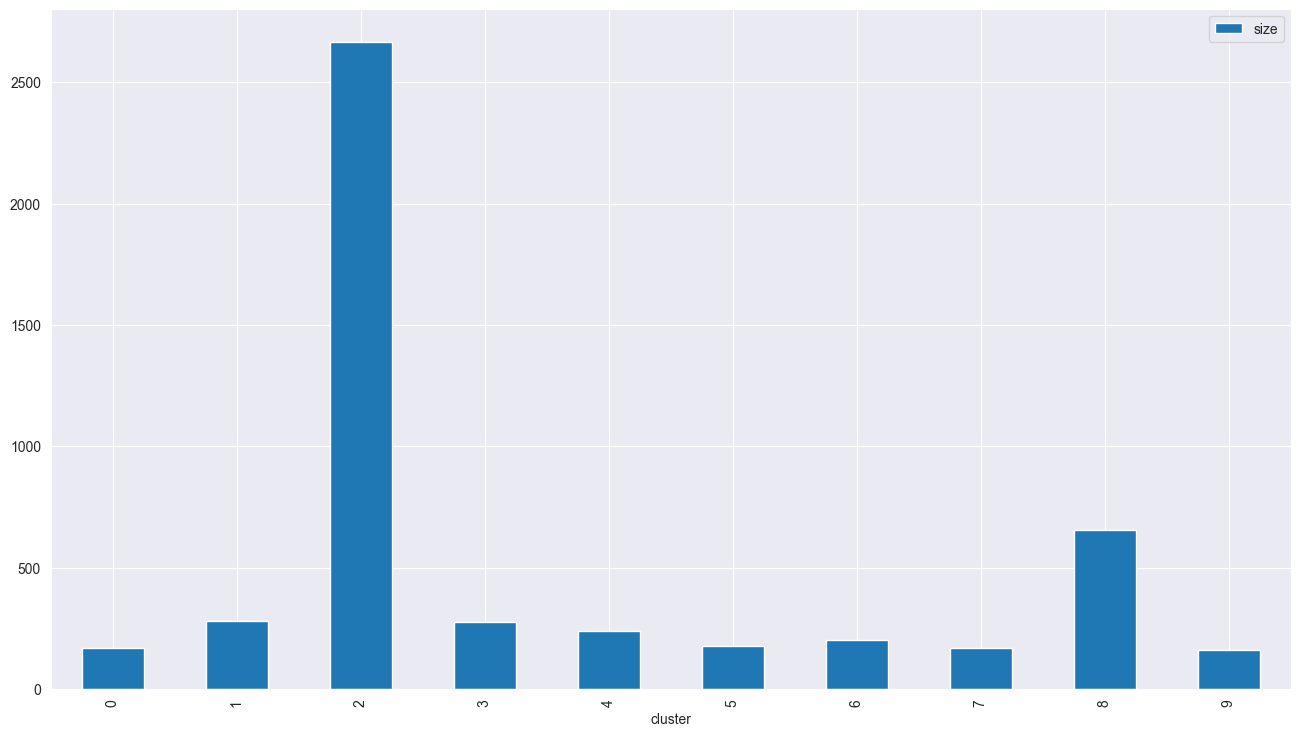

In [9]:
sizes = []
for i in range(10):
    sizes.append({"cluster": i, "size": np.sum(k_means_para.labels_==i)})
pd.DataFrame(sizes).set_index("cluster").plot.bar(figsize=(16,9))



In [16]:
nmf_vectors.shape

(5000, 7852)

In [15]:
len(k_means_para.labels_)

5000

In [26]:
nmf_vectors

<5000x7852 sparse matrix of type '<class 'numpy.float64'>'
	with 183997 stored elements in Compressed Sparse Row format>

In [27]:
k_means_para.labels_.shape

(5000,)

In [31]:
type(nmf_vectorizer.get_feature_names())

list

In [29]:
no_top_words = 5
features = nmf_vectorizer.get_feature_names()
sizes = {}
for cluster in np.unique(k_means_para.labels_):
    size = []
    words = nmf_vectors[k_means_para.labels_ == cluster].sum(axis=0).A[0]
    print(words.shape)
    largest = words.argsort()[::-1] # invert sort order
    for i in range(0, no_top_words):
        size += [(features[largest[i]], abs(words[largest[i]]))]
    sizes[cluster] = size
print(sizes)
    #wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
    #wc.generate_from_frequencies(size)
    #plt.figure(figsize=(12,12))
    #plt.imshow(wc, interpolation='bilinear')
    #plt.axis("off")
    # if you don't want to save the topic model, comment the next line
    #plt.savefig(f'cluster{cluster}.png')



(7852,)
(7852,)
(7852,)
(7852,)
(7852,)
(7852,)
(7852,)
(7852,)
(7852,)
(7852,)
{0: [('nuclear', 27.875605467119954), ('weapons', 22.545058483036406), ('nuclear weapons', 11.601438192335468), ('disarmament', 8.750604828192134), ('proliferation', 8.474786822341727)], 1: [('council', 36.78460390834767), ('security', 33.40211015171649), ('security council', 30.153911972947963), ('international', 10.003329459761192), ('peace', 9.628488862448158)], 2: [('international', 55.14080629691653), ('world', 52.399867241196304), ('peace', 47.145798763635085), ('people', 44.753295011295535), ('country', 43.27223265334495)], 3: [('session', 31.56641376484243), ('assembly', 27.540397395098076), ('general assembly', 25.877249795030824), ('general', 22.936863338084127), ('session general assembly', 19.55156593958284)], 4: [('israel', 20.759430948074137), ('middle east', 18.885890097865015), ('middle', 18.582000056834822), ('east', 18.255887100047946), ('palestinian', 18.02535850869501)], 5: [('secretary 

In [24]:
pd.DataFrame(sizes)

,0,1,2,3,4,5,6,7,8,9
0,"(nuclear, 27.875605467119954)","(council, 36.78460390834767)","(international, 55.14080629691653)","(session, 31.56641376484243)","(israel, 20.759430948074137)","(secretary general, 22.80904654995647)","(rights, 34.11201053087052)","(operation, 20.252788847177364)","(countries, 52.92944805120449)","(africa, 25.442894922687156)"
1,"(weapons, 22.545058483036406)","(security, 33.40211015171649)","(world, 52.399867241196304)","(assembly, 27.540397395098076)","(middle east, 18.885890097865015)","(secretary, 22.50157189468826)","(human rights, 33.04952682664063)","(co operation, 20.247985612046705)","(development, 43.78902837296603)","(south, 24.156265135332326)"
2,"(nuclear weapons, 11.601438192335468)","(security council, 30.153911972947963)","(peace, 47.145798763635085)","(general assembly, 25.877249795030824)","(middle, 18.582000056834822)","(general, 18.108154509085843)","(human, 32.1990460454565)","(co, 19.744914074783207)","(economic, 39.80846321839231)","(south africa, 21.731845922871166)"
3,"(disarmament, 8.750604828192134)","(international, 10.003329459761192)","(people, 44.753295011295535)","(general, 22.936863338084127)","(east, 18.255887100047946)","(organization, 6.393692572288739)","(respect, 6.529900817570694)","(international, 7.5033621135189215)","(developing, 35.65433381200464)","(namibia, 11.362610786001099)"
4,"(proliferation, 8.474786822341727)","(peace, 9.628488862448158)","(country, 43.27223265334495)","(session general assembly, 19.55156593958284)","(palestinian, 18.02535850869501)","(mr, 5.952200111451257)","(international, 5.834623171724585)","(countries, 5.035571474250511)","(developing countries, 30.061858701543162)","(apartheid, 9.278117350367523)"


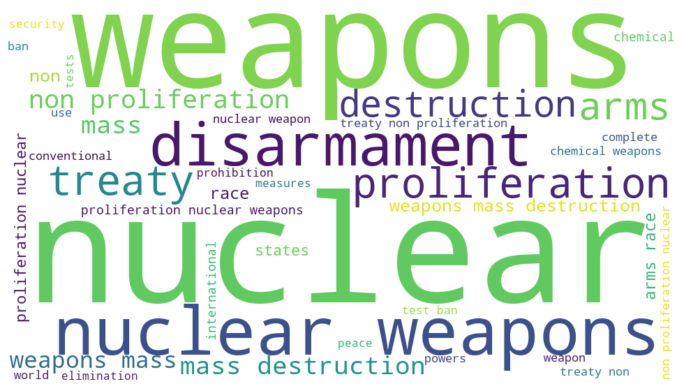

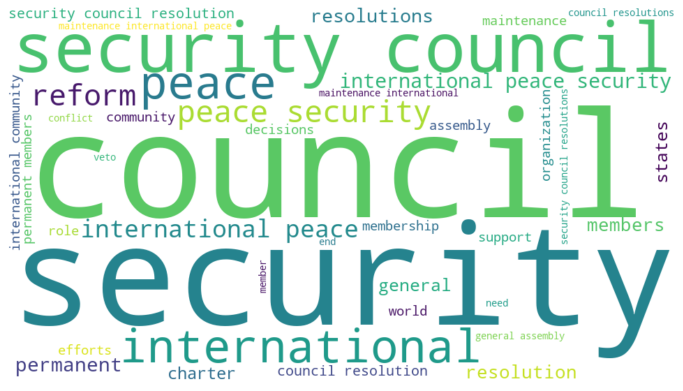

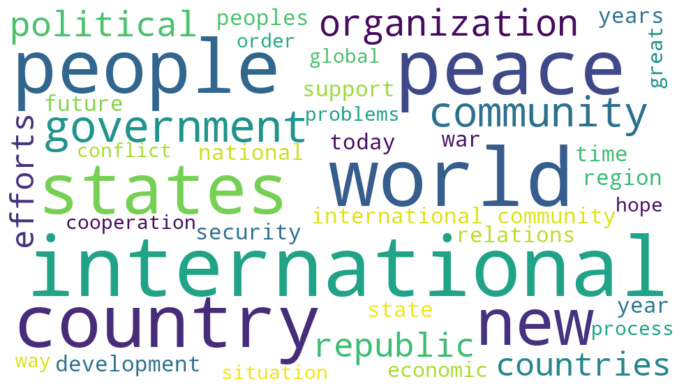

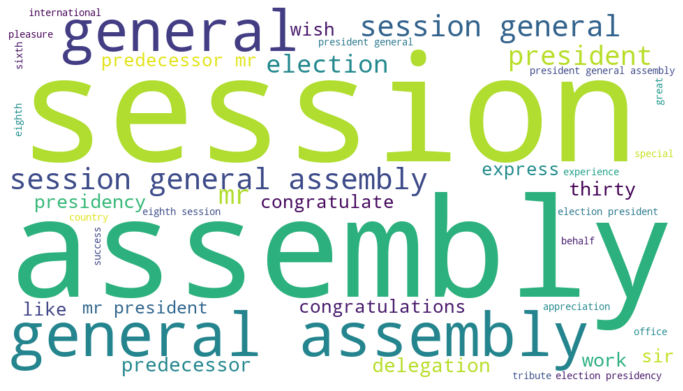

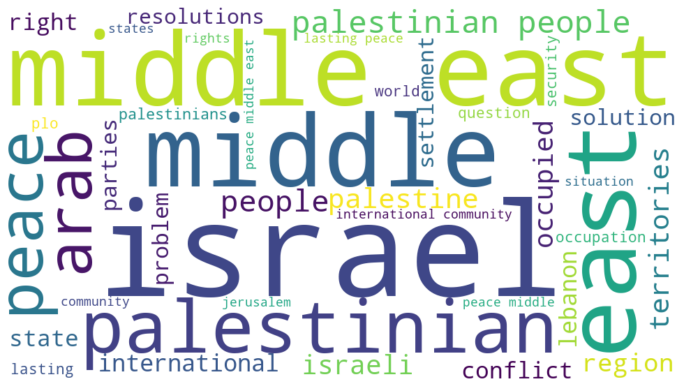

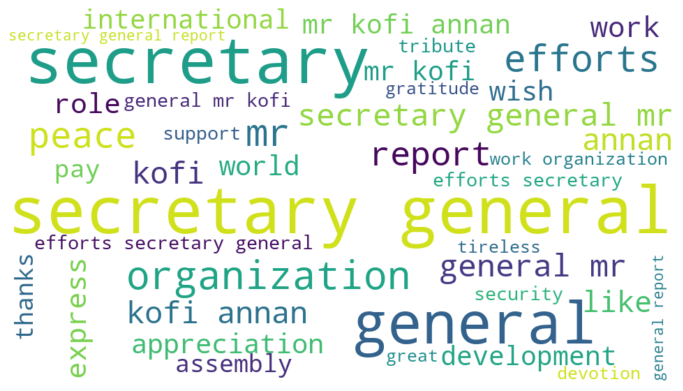

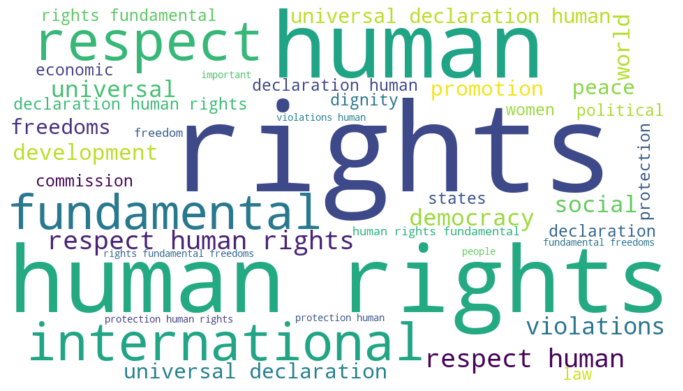

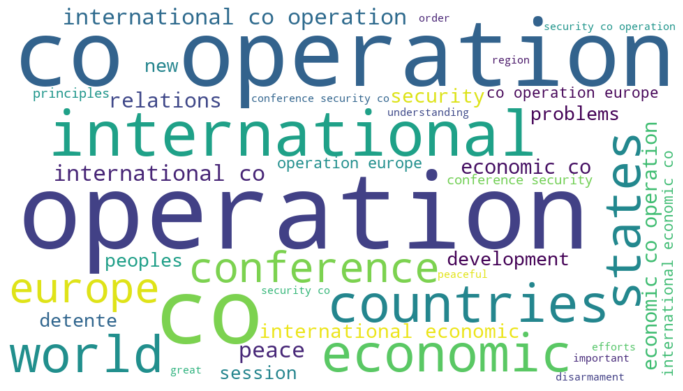

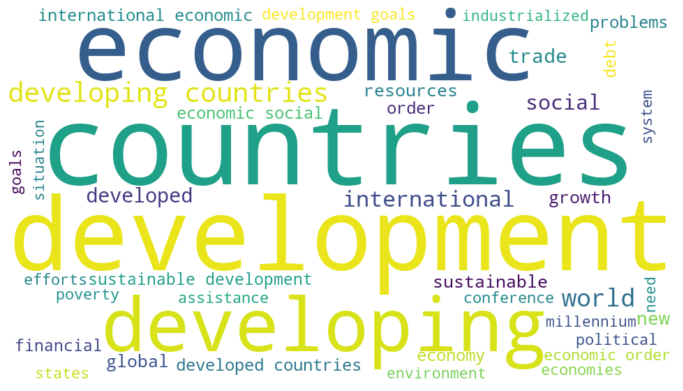

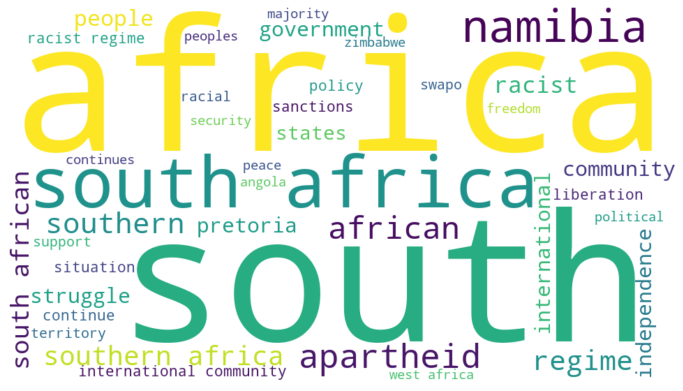

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def wordcloud_clusters(model, vectors, features, no_top_words=40):
    for cluster in np.unique(model.labels_):
        size = {}
        words = vectors[model.labels_ == cluster].sum(axis=0).A[0]
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        # if you don't want to save the topic model, comment the next line
        plt.savefig(f'cluster{cluster}.png')


wordcloud_clusters(k_means_para, nmf_vectors, nmf_vectorizer.get_feature_names())




# Topic Modeling

## NMF

In [ ]:
nmf_explorer = TopicModelExplorer(model=nmf_model, vectorizer=nmf_vectorizer)

### Overview

In [ ]:
nmf_explorer.plot_topics(
    top_n_tokens=8,
    num_tokens_in_label=2
)

In [ ]:
nmf_explorer.plot_topic_sizes(text_series=paragraphs['text'])

In [ ]:
predicted_topics = nmf_model.transform(X=nmf_vectorizer.transform(paragraphs['text']))
per_document_totals = predicted_topics.sum(axis=1)
ax = pd.Series(per_document_totals).plot(kind='box', vert=False, figsize=(10, 1))
ax.set_title("Distribution Sum of Predicted Values/Topics Per Document")
ax.set_xlabel("Sum of Predicted Values Per Document")
ax.set_yticklabels([])
ax;

---

### Trends

In [ ]:
topic_sizes_per_year = nmf_explorer.get_topic_sizes_per_segment(
    df=paragraphs,
    text_column='text',
    segment_column='year',
)
topic_sizes_per_year.head()

In [ ]:
fig = px.area(
    topic_sizes_per_year,
    x="year",
    y="relative_size",
    color="topic_labels",
    title="Topics Over Time",
)
fig.show()

In [ ]:
fig = px.bar(
    topic_sizes_per_year,
    x="year",
    y="relative_size",
    color="topic_labels",
    title="Topics Over Time",
)
fig.show()

In [ ]:
fig = px.line(
    topic_sizes_per_year,
    x="year",
    y="relative_size",
    color="topic_labels",
    title="Topics Over Time",
)
fig.show()

In [ ]:
fig = px.scatter(
    topic_sizes_per_year,
    x="year",
    y="relative_size",
    color="topic_labels",
    trendline="lowess",
    opacity=0.0,
    title="Topics Over Time",
)
fig.show()

---

### Examples

In [ ]:
top_examples = nmf_explorer.extract_top_examples(
    text_series=paragraphs['text'],
    top_n_examples=10
)
top_examples.style.hide(axis='index')

---

## LDA

Neither the book nor the example above uses TF-IDF with LDA, but do not specify why. Both use TF-IDF with NMF and then change to CountVectorizer with LDA


https://stackoverflow.com/questions/44781047/necessary-to-apply-tf-idf-to-new-documents-in-gensim-lda-model/44789327#44789327

> LDA only needs a bag-of-word vector.



In [ ]:
lda_explorer = TopicModelExplorer(model=lda_model, vectorizer=lda_vectorizer)

### Overview

In [ ]:
lda_explorer.plot_topics(
    top_n_tokens=8,
    num_tokens_in_label=2,
    token_separator=' | '
)

In [ ]:
lda_explorer.plot_topic_sizes(
    text_series=paragraphs['text'],
    num_tokens_in_label=3,
    token_separator=' | '
)

In [ ]:
predicted_topics = lda_model.transform(X=lda_vectorizer.transform(paragraphs['text']))
per_document_totals = predicted_topics.sum(axis=1)
ax = pd.Series(per_document_totals).plot(kind='box', vert=False, figsize=(10, 1))
ax.set_title("Distribution Sum of Predicted Values/Topics Per Document")
ax.set_xlabel("Sum of Predicted Values Per Document")
ax.set_yticklabels([])
ax;

---

### Trends

In [ ]:
topic_sizes_per_year = lda_explorer.get_topic_sizes_per_segment(
    df=paragraphs,
    text_column='text',
    segment_column='year',
)
topic_sizes_per_year.head()

In [ ]:
fig = px.area(
    topic_sizes_per_year,
    x="year",
    y="relative_size",
    color="topic_labels",
    title="Topics Over Time",
)
fig.show()

In [ ]:
fig = px.bar(
    topic_sizes_per_year,
    x="year",
    y="relative_size",
    color="topic_labels",
    title="Topics Over Time",
)
fig.show()

In [ ]:
fig = px.line(
    topic_sizes_per_year,
    x="year",
    y="relative_size",
    color="topic_labels",
    title="Topics Over Time",
)
fig.show()

In [ ]:
fig = px.scatter(
    topic_sizes_per_year,
    x="year",
    y="relative_size",
    color="topic_labels",
    trendline="lowess",
    opacity=0.0,
    title="Topics Over Time",
)
fig.show()

---

### Examples

In [ ]:
top_examples = lda_explorer.extract_top_examples(
    text_series=paragraphs['text'],
    top_n_examples=10
)
top_examples.style.hide(axis='index')

---

In [ ]:
import pyLDAvis.sklearn

lda_display = pyLDAvis.sklearn.prepare(lda_model, lda_vectors, lda_vectorizer, sort_topics=False)
# pyLDAvis.display(lda_display)

file_name = f"docs/models/topics/lda-n-grams-{ngrams_low}-{ngrams_high}.html"
pyLDAvis.save_html(lda_display, file_name)

---